# Boundary conditions and numerical stability

Let's take a closer look at the problem from [Homework 5](https://andrewcumming.github.io/phys512/hw5.html) where we solved the thermal diffusion equation

$${\partial T\over \partial t} = {\partial^2 T\over \partial x^2}.$$

We first differenced the right hand side on a grid to get

$${dT_i\over dt} = {T_{i+1}-2T_i+T_{i-1}\over (\Delta x)^2},$$

where $i$ labels the grid point. Using the implicit backwards-Euler method to integrate in time gives

$$T^{n+1}_i = T^n_i + \Delta t \left( {T^{n+1}_{i+1}-2T^{n+1}_i+T^{n+1}_{i-1}\over (\Delta x)^2} \right),$$

where now the superscript $n$ labels the time.

With $\alpha \equiv \Delta t/(\Delta x)^2$ this becomes

$$T^{n+1}_i = T^n_i + \alpha \left( T^{n+1}_{i+1}-2T^{n+1}_i+T^{n+1}_{i-1}\right),$$

or

$$-\alpha T^{n+1}_{i-1} + (1+2\alpha) T^{n+1}_i -\alpha T^{n+1}_{i+1} = T^n_i.$$(update)

This is of the form $\mathbf{A}\mathbf{T}^{n+1} = \mathbf{T}^n$ where the matrix $\mathbf{A}$ is tridiagonal with $-\alpha$ on the upper and lower diagonals and $1-2\alpha$ on the main diagonal. 

## Boundary conditions

There are a couple of different ways to handle the boundary conditions. Consider the case from the homework question, where the temperature was fixed at the each side of the grid.

**Option 1: make the boundary points part of our grid.** In this case, we want equation {eq}`update` to apply for $i=2,\dots N-1$, but for $i=1$ and $i=N$ we need

$$T^{n+1}_1 = T^n_1; \hspace{1cm} T^{n+1}_N = T^n_N.$$

To implement this, we need to modify the first and last rows of the matrix. For example, with 5 grid points this would look like:

$$\mathbf{A} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
-\alpha & 1+2\alpha & -\alpha & 0 & 0 \\
0 & -\alpha & 1+2\alpha & -\alpha & 0 \\
0 & 0 & -\alpha & 1+2\alpha & -\alpha \\
0 & 0 & 0 & 0 & 1
\end{pmatrix}$$

We set the values at the boundaries at the beginning of the calculation, and they don't change when we update the grid from one timestep to another. This is the approach taken in the [homework solutions](https://andrewcumming.github.io/phys512/HW5_solutions.html).

**Option 2: move the boundary information to the other side of the equation.** Instead of changing the matrix, we add the additional information from the boundaries as a correction. 

For example, if the boundary conditions are $T(x=0)=T_a$ and $T(x=1)=T_b$. Then the update equations for the left-most and right-most grid points become

$$-\alpha T_a + (1+2\alpha) T^{n+1}_1 -\alpha T^{n+1}_2 = T^n_1$$

and

$$-\alpha  T^{n+1}_{N-1} + (1+2\alpha) T^{n+1}_N -\alpha T_b = T^n_N.$$

Move the boundary terms to the right-hand side:

$$(1+2\alpha) T^{n+1}_1 -\alpha T^{n+1}_2 = T^n_1 + \alpha T_a$$
$$-\alpha  T^{n+1}_{N-1} + (1+2\alpha) T^{n+1}_N = T^n_N + \alpha T_b.$$

Now we have an equation of the form

$$\mathbf{A} \mathbf{T}^{n+1} = \mathbf{T}^n + \alpha\mathbf{b}$$

where matrix $\mathbf{A}$ no longer needs any corrections, we can keep the original tridiagonal matrix, instead we include the boundary conditions by adding a vector $\mathbf{b} = (T_a, 0,0,\dots T_b)$ to the right-hand side. This can be a much simpler approach than figuring out how to modify the matrix.

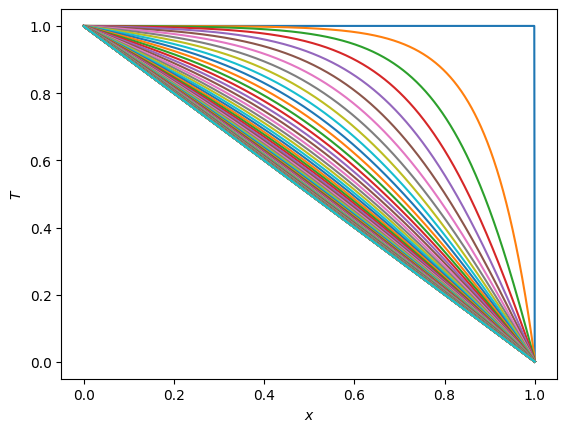

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

n = 1001
x = np.linspace(0, 1, n)

# Initial profile has T=1 everywhere except T=0 at the outer boundary
T = np.ones(n)
T[-1] = 0.0

plt.plot(x, T)
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')

dx = x[1]-x[0]
dt = 1e-2
alpha = dt/dx**2
nsteps = 100

# Calculate the matrix A in banded form
b = (1 + 2*alpha) * np.ones(n)
a = -alpha * np.ones(n)
c = -alpha * np.ones(n)
c[-1] = 0.0
a[0] = 0.0
AA = np.row_stack((a,b,c))

# and the b vector (boundaries)
bvec = np.zeros(n)
bvec[0] = 1

for i in range(1,nsteps):

    T = scipy.linalg.solve_banded((1,1), AA, T + alpha*bvec)
    plt.plot(x, T)

plt.show()

Note that you can show an animated plot while the simulation is running using `%matplotlib` before plotting which will open the plot in a separate window. You can switch back to inline with `%matplotlib inline`. Here is a version that animates the solution:

[The only issue with this is that I find that once I switch back to inline I'm not able to close the external matplotlib window, if anyone has a fix for this, please let me know!]

Using matplotlib backend: MacOSX


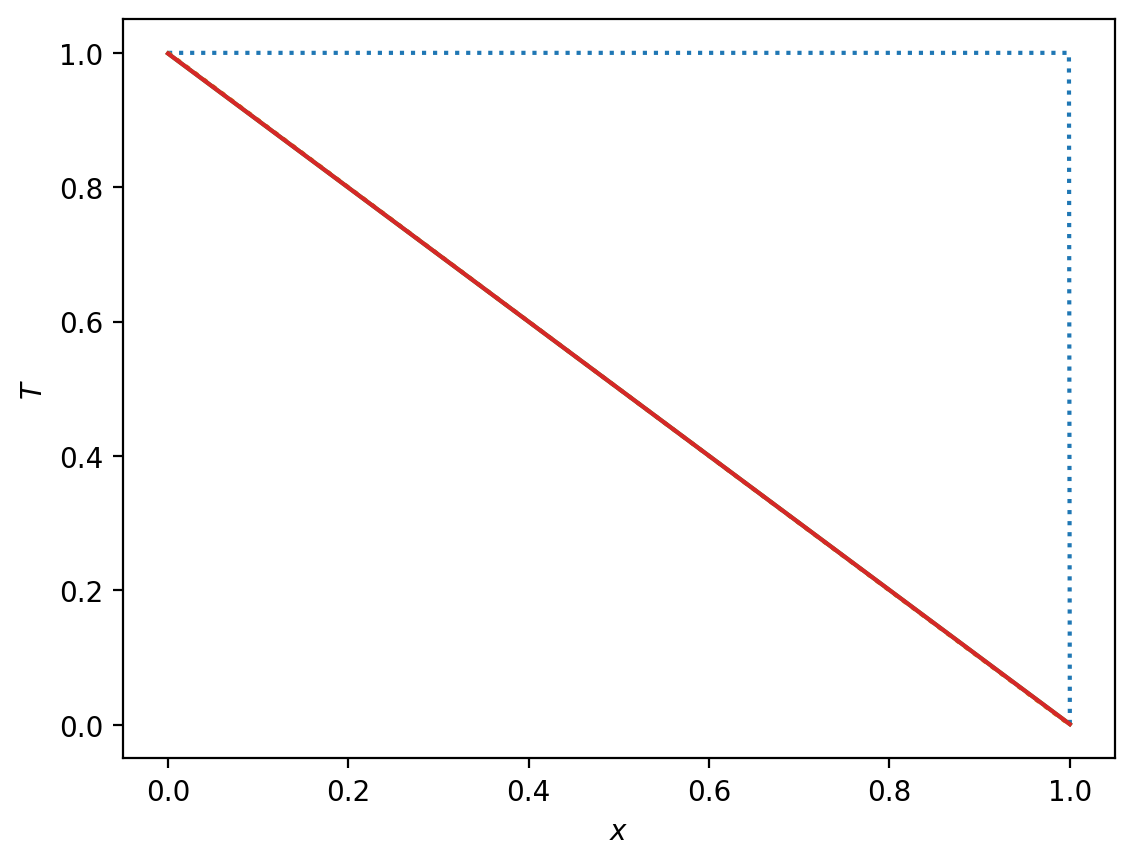

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

n = 1001
x = np.linspace(0, 1, n)

# Initial profile has T=1 everywhere except T=0 at the outer boundary
T = np.ones(n)
T[-1] = 0.0

%matplotlib
plt.plot(x, T, ":")
plt.plot(x, 1-x, ":")
plot1, = plt.plot(x, T)
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')

dx = x[1]-x[0]
dt = 1e-2
alpha = 0.1 * dt/dx**2
nsteps = 1000

# Calculate the matrix A in banded form
b = (1 + 2*alpha) * np.ones(n)
a = -alpha * np.ones(n)
c = -alpha * np.ones(n)
c[-1] = 0.0
a[0] = 0.0
AA = np.row_stack((a,b,c))

# and the b vector (boundaries)
bvec = np.zeros(n)
bvec[0] = 1

for i in range(1,nsteps):

    T = scipy.linalg.solve_banded((1,1), AA, T + alpha*bvec)
    plot1.set_ydata(T)
    plt.draw()
    plt.pause(1e-3)

%matplotlib inline
plt.plot(x, T)
plt.show()

```{admonition} Exercise: boundary conditions

Solve the problem above but modified so that the boundary condition at $x=0$ is insulating ($dT/dx=0$) rather than fixed temperature.

```

## Numerical stability

We mentioned the idea of numerical stability when we talked about explicit vs implicit methods for initial value problems. An explicit update is generally stable only for a small timestep, whereas the implicit method above for example is stable for arbitrarily large time steps. Furthermore, you can see from the update equation {eq}`update` that large timesteps force the solution to steady state ($\partial^2 T/\partial x^2=0$). Short wavelengths are not followed accurately with large timesteps, but adopt their steady-state solution. This makes physical sense - on timescales long compared to the local diffusion time, we expect the system to go to steady-state.

We can assess the stability of a numerical scheme using **von Neumann stability analysis**. For example, the explicit Euler method for the diffusion equation above gives

$$T^{n+1}_j = \alpha T^n_{j-1} + (1-2\alpha) T^n_j +\alpha T^n_{j+1}.$$(explicit)

(I've switched the index from $i$ to $j$ because we will soon be using $i$ as square root of minus one).

To check the stability of the method, we now look for a solution 

$$T^n_j = \xi^n e^{ikx} = \xi^n e^{ik(j\Delta x)}.$$

The idea is that if $|\xi|>1$ for any wavevector $k$ then the scheme is unstable because $T_j$ will grow exponentially with time.

Substituting this solution into equation {eq}`explicit` gives

$$e^{ikj\Delta x}\xi^{n+1} = \alpha e^{ik(j-1)\Delta x}\xi^n +(1-2\alpha) e^{ikj\Delta x}\xi^n + \alpha e^{ik(j+1)\Delta x}\xi^n$$

$$\Rightarrow \xi = \alpha e^{-ik\Delta x} + (1-2\alpha) + \alpha e^{ik\Delta x}$$

$$\Rightarrow \xi = 1 - 2\alpha \left(1-\cos(k\Delta x)\right)$$

$$\Rightarrow \xi = 1 - 4\alpha \sin^2\left({k\Delta x\over 2}\right)$$

We need $2\alpha < 1$ in order to keep $|\xi|<1$ (or $-1\leq \xi\leq 1$), i.e.

$$\alpha = {\Delta t\over (\Delta x)^2}< 1/2$$ 

for stability. Note that this has a physical interpretation - we need the timestep to be shorter than the diffusion time across a grid cell for the method to be stable. 

For values of $\alpha > 1/2$, the largest value of $|\xi|$ corresponds to $\sin^2 (k\Delta x/2)=1$ or $k\Delta x/2 = \pi/2$. The wavelength of this most-unstable mode is 

$$\lambda = {2\pi\over k} = 2\Delta x.$$

```{admonition} Stability analysis

Check the stability of the implicit Euler method and show that all wavelengths are stable no matter what the timestep.
```

```{admonition} Exercise: unstable solutions

Change the code above to use an explicit update rather than implicit. Run it for $\alpha>1/2$. Does the unstable solution look the way you expect given our stability analysis?

```